# Introuction

* paper : https://arxiv.org/pdf/1409.4842

* InceptionNet, also known as GoogleNet, was introduced by Google in the paper “Going Deeper with Convolutions” in 2014, during the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).
* Before InceptionNet, models like AlexNet and VGGNet increased depth to boost accuracy, but this led to a explosion in parameters, causing overfitting, high computational costs, and vanishing gradient issues
* ResNet later tackled this problem with skip connections to avoid vanishing gradients.
* InceptionNet introduced a more efficient way to increase depth and width by carefully designing the architecture to optimize computation.

## Key Concepts of the Architecture:
* The main innovation of GoogleNet/InceptionNet is the Inception Module:

* Inception Module: Instead of stacking layers sequentially, the inception module processes input using multiple convolutions and pooling operations in parallel. It uses:
 - 1x1 Convolutions: To reduce dimensionality and computational cost.
 - 3x3 and 5x5 Convolutions: For capturing medium and larger receptive fields.
 - Max Pooling: To capture spatial hierarchies.
 - All these outputs are concatenated together, which allows the network to gather multiple levels of feature abstraction simultaneously.
 - Auxiliary Classifiers:
   - The GoogleNet also incorporated auxiliary classifiers in intermediate layers to help prevent vanishing gradients and improve learning for deeper layers.
   - These classifiers are applied after specific layers in the network to improve convergence during training by providing intermediate supervision.

# Implementation

In [6]:
!pip install torchview

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchview import draw_graph

In [8]:
class InceptionBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 ch1x1,ch3x3_reduce,ch3x3,ch5x5_reduce,ch5x5,
                 pool_proj
                 ):

        super(InceptionBlock,self).__init__()


        self.brach1x1 = nn.Conv2d(in_channels,ch1x1,kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels,ch3x3_reduce,kernel_size=1),
            nn.Conv2d(ch3x3_reduce,ch3x3,kernel_size=3,padding=1)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels,ch5x5_reduce,kernel_size=1),
            nn.Conv2d(ch5x5_reduce,ch5x5,kernel_size=5,padding=2)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            nn.Conv2d(in_channels,pool_proj,kernel_size=1)
        )


    def forward(self,x):

        branch1x1 = self.brach1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        outputs = [branch1x1,branch3x3,branch5x5,branch_pool]

        return torch.cat(outputs,1)

In [21]:
from typing import ParamSpecArgs
class InceptionNet(nn.Module):
    def __init__(self,num_classes=1000):
        super(InceptionNet,self).__init__()


        self.pre_layer = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(64,192,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )


        # inception blocks

        self.inception3a = InceptionBlock(192,64,96,128,16,32,32)
        self.inception3b = InceptionBlock(256,128,128,192,32,96,64)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.inception4a = InceptionBlock(480,192,96,208,16,48,64)
        self.inception4b = InceptionBlock(512,160,112,224,24,64,64)
        self.inception4c = InceptionBlock(512,128,128,256,24,64,64)
        self.inception4d = InceptionBlock(512,112,144,288,32,64,64)
        self.inception4e = InceptionBlock(528,256,160,320,32,128,128)


        self.inception5a = InceptionBlock(832,256,160,320,32,128,128)
        self.inception5b = InceptionBlock(832,384,193,384,48,128,128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024,num_classes)

        self.aux1 = self._make_aux_classifier(512,num_classes)
        self.aux2 = self._make_aux_classifier(832,num_classes)

    def _make_aux_classifier(self,in_channels,num_classes):

        return nn.Sequential(
            nn.AvgPool2d(kernel_size=5,stride=3),
            nn.Conv2d(in_channels,128,kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,768,kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(768,num_classes)

        )

    def forward(self,x):

        x = self.pre_layer(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)


        x = self.inception4a(x)
        aux1 = self.aux1(x) if self.training else None

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2 = self.aux2(x) if self.training else None

        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        if self.training:
            return x, aux1, aux2

        else:
            return x



In [22]:
inception_model = InceptionNet()

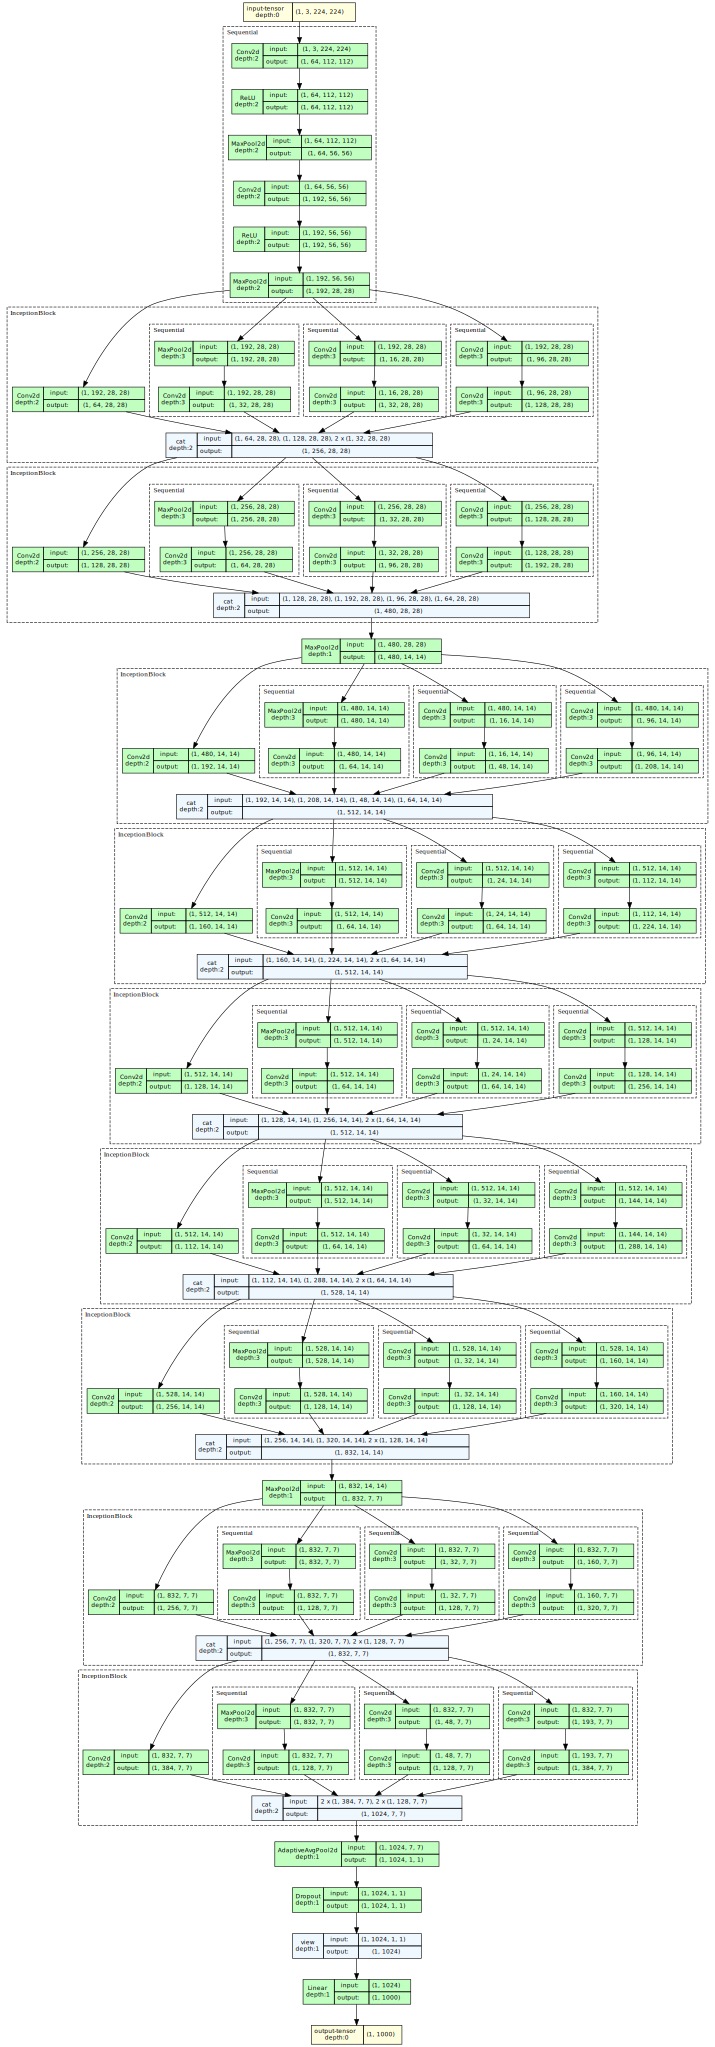

In [23]:
draw_graph(inception_model,input_size=(1,3,224,224),expand_nested=True).visual_graph